In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

In [2]:
# !pip install pandas
# !pip install matplotlib
# !pip install tqdm

In [134]:
class Stock:
    def __init__(self,symbol, directory='/home/ashli/ML/data/stocks'):
        self.symbol = symbol
        self.directory = directory
        self.load_data(directory)
        

    def load_data(self,directory):
        file_path = os.path.join(directory,f"{self.symbol}.csv")
        if os.path.exists(file_path):
            self.data = pd.read_csv(file_path)
            self.data['Date'] = pd.to_datetime(self.data['Date'])
            self.data = self.data.set_index(self.data['Date'])
            self.data = self.data.sort_index()
        else:
            raise FileNotFoundError(f"CSV file for symbol {self.symbol} not found in directory")
            
    def trim_by_date(self, start_date,end_date):
        self.data['Date'] = pd.to_datetime(self.data['Date'])
        trim_data = self.data[(self.data['Date'] >= start_date) & (self.data['Date'] <= end_date)]
        return trim_data

    def isolate_dates(self, ref_stock):
        if len(set(ref_stock.data["Date"])-set(self.data["Date"]))>0:
            # print("missing overlapping dates with reference stock")
            return False
        self.data = self.data.loc[list(ref_stock.data["Date"])]
        return True

    def find_corr(self, ref_stock, column="Close"):
        return self.data[column].corr(ref_stock.data[column])
            
    def get_stock_data_by_date(self,date):
        if self.data is not None:
            stock_data = self.data[self.data['Date'] == date]
            if not stock_data.empty:
                return stock_data.iloc[0].to_dict()
            else:
                return f"No data available for {self.symbol} on {date}"
        else:
            return "Data not loaded. Please load the csv file first."

        

In [52]:
directory = '/home/ashli/ML/data/stocks'

In [121]:
tsla = Stock('TSLA')

In [122]:
tsla.isolate_dates(tsla)

True

In [123]:
amzn = Stock('AMZN')
amzn_dates = set(amzn.data['Date'])

In [124]:
amzn.isolate_dates(tsla)

True

In [125]:
tsla.find_corr(amzn),amzn.find_corr(tsla)

(np.float64(0.7522800780420281), np.float64(0.7522800780420281))

In [126]:
dates = amzn_dates - tsla_dates
len(dates)

3301

In [34]:
amzn_filtered = amzn.data.loc[list(tsla_dates)]

In [37]:
amzn_filtered["Close"].corr(tsla.data["Close"])

np.float64(0.7522800780420281)

In [5]:
def plot_stock_data(stock):
    if stock.data is not None:
        plt.figure(figsize = (10,6))
        
        # plt.plot(stock.data['Date'], stock.data['Open'], label='Open', color='green')
        # plt.plot(stock.data['Date'], stock.data['High'], label='High', color='blue')
        # plt.plot(stock.data['Date'], stock.data['Low'], label='Low', color='red')
        plt.plot(stock.data['Date'], stock.data['Close'], label='Close', color='orange')

        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.title(f"Stock price for {stock.symbol}")
        plt.legend()
        plt.grid(True)

        plt.show()
    else:
        print("Data not loaded. Please load the csv file first.")

In [6]:
def moving_avg(stock,period):
    if stock.data is not None:
        df = pd.DataFrame(stock.data, columns=['Close'])
        df['SMA'] = df['Close'].rolling(window=period).mean()
        return df

In [127]:
def get_stocks(directory):
    stocks_before_2010 = []
    for filename in tqdm(os.listdir(directory)):
        file_path = os.path.join(directory,filename)
        if not file_path.endswith(".csv"): continue
        df = pd.read_csv(file_path)
        df['Date'] = pd.to_datetime(df['Date'])
        start_date = df['Date'].min()
        if start_date.year < 2010:
            stocks_before_2010.append(filename.split('.')[0])
    return stocks_before_2010

In [128]:
stock_list = get_stocks(directory)

100%|███████████████████████████████████████| 5885/5885 [01:22<00:00, 70.93it/s]


In [129]:
len(stock_list)

3439

In [135]:
def corr_stocks(stock_list):
    corr_dict = {}
    ref_stock = Stock('TSLA')
    for stock in tqdm(stock_list):
        stock_obj = Stock(stock)
        if stock_obj.isolate_dates(ref_stock):
            corr_dict[stock_obj.symbol] = stock_obj.find_corr(ref_stock)
    return corr_dict
            

In [136]:
corr_dict = corr_stocks(stock_list)

100%|███████████████████████████████████████| 3439/3439 [03:00<00:00, 19.07it/s]


In [137]:
corr_dict

{'OLN': np.float64(0.27012011030361816),
 'ADES': np.float64(0.11483407930594546),
 'CRVL': np.float64(0.7711193464887848),
 'SCU': np.float64(-0.633441780392216),
 'ALBO': np.float64(-0.5665400529800875),
 'CPAH': np.float64(-0.7892128501007084),
 'MPA': np.float64(-0.38553557607678135),
 'IIVI': np.float64(0.5449291565537596),
 'BBAR': np.float64(0.38215429789150324),
 'ADP': np.float64(0.8103311900003328),
 'TPC': np.float64(0.1920862417792281),
 'MLNX': np.float64(0.48772656079360865),
 'GBR': np.float64(-0.3038170633703696),
 'DBD': np.float64(-0.591503935292784),
 'ESTE': np.float64(-0.34700592922273665),
 'NEPT': np.float64(-0.24278100567947686),
 'SBUX': np.float64(0.8038198154494893),
 'HTBK': np.float64(0.7699249547423924),
 'WBK': np.float64(-0.2599329559292802),
 'ERF': np.float64(-0.6623620086212412),
 'UBOH': np.float64(0.8476306713503556),
 'ELGX': np.float64(-0.46750983334343643),
 'ITRN': np.float64(0.74737737716772),
 'YUM': np.float64(0.7394502328378659),
 'AEL': np.

In [138]:
# corr_dict[min(corr_dict,key=corr_dict.get)
min_key, min_value = min(corr_dict.items(), key=lambda x: x[1])

In [139]:
min_key,min_value

('MIN', np.float64(-0.8644315164294902))

In [140]:
min(corr_dict,key=corr_dict.get)

'MIN'

In [141]:
max(corr_dict,key=corr_dict.get)
max_key, max_value = max(corr_dict.items(), key=lambda x: x[1])

In [142]:
max_key,max_value

('RELX', np.float64(0.892577488505679))

In [143]:
sorted_by_values = dict(sorted(corr_dict.items(), key=lambda item: item[1]))

In [144]:
sorted_by_values

{'MIN': np.float64(-0.8644315164294902),
 'MGF': np.float64(-0.855581191404312),
 'DO': np.float64(-0.8417379923421046),
 'JAKK': np.float64(-0.8395657559980063),
 'EGF': np.float64(-0.8369241486006322),
 'GIM': np.float64(-0.8343503303398302),
 'GGN': np.float64(-0.8318775247046458),
 'NRT': np.float64(-0.8310255770132061),
 'ACHV': np.float64(-0.8281378918225877),
 'ARR': np.float64(-0.8261516654579598),
 'IDXG': np.float64(-0.8251659647921761),
 'EGO': np.float64(-0.8244609218924903),
 'JE': np.float64(-0.8237562050596805),
 'TEI': np.float64(-0.8228884853602848),
 'EDD': np.float64(-0.8219242810279722),
 'JCP': np.float64(-0.8215510365788696),
 'KOSS': np.float64(-0.8210437757978786),
 'FMY': np.float64(-0.8205717300048687),
 'CVE': np.float64(-0.8192141657962992),
 'NGD': np.float64(-0.8174568517150961),
 'BBI': np.float64(-0.8172885176064173),
 'FAX': np.float64(-0.816301229103267),
 'GDL': np.float64(-0.81627176486374),
 'DUC': np.float64(-0.8158614620008048),
 'CLNE': np.float6

In [151]:
def plot_graph(a_sym,b_sym):
    stock_a = Stock(a_sym)
    stock_b = Stock(b_sym)
    stock_b.isolate_dates(stock_a)
    plt.figure(figsize=(10,6))
    plt.plot(stock_a.data['Date'], stock_a.data['Open'], label=a_sym, color='red')
    plt.plot(stock_b.data['Date'], stock_b.data['Open'], label=b_sym, color='green')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

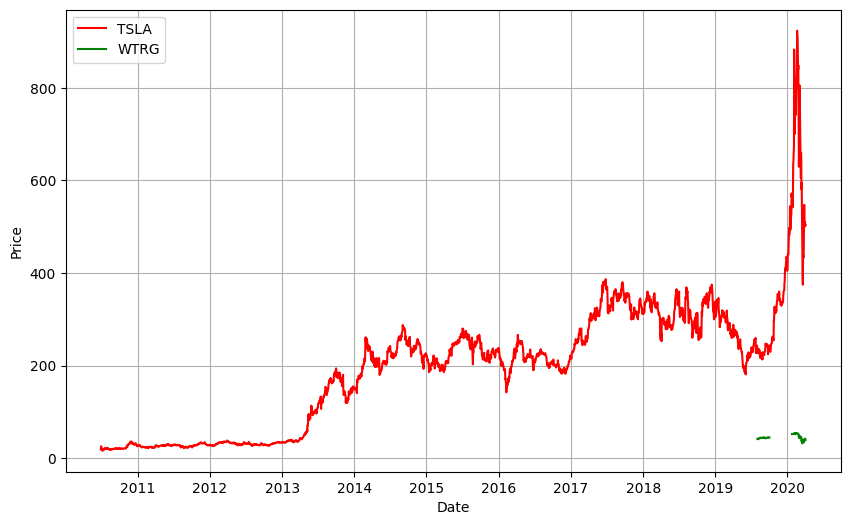

In [183]:
plot_graph('TSLA','WTRG')

In [155]:
sample_stock = random.sample(stock_list,100)

In [156]:
sample_stock

['UONEK',
 'AES',
 'CFBK',
 'BNS',
 'CTXS',
 'ARGO',
 'USLM',
 'GFY',
 'INFI',
 'HHT',
 'AFG',
 'LUNA',
 'DIN',
 'PTR',
 'SNY',
 'IMKTA',
 'AIG',
 'UVSP',
 'GBCI',
 'LOGI',
 'TEF',
 'PYT',
 'CTB',
 'WWD',
 'BAP',
 'SIG',
 'CII',
 'PVH',
 'SWX',
 'CET',
 'ICAD',
 'MLHR',
 'TWIN',
 'BXC',
 'GILT',
 'NJV',
 'OSW',
 'HMN',
 'SM',
 'CSGP',
 'CNSL',
 'EVF',
 'SIF',
 'GIS',
 'ELP',
 'APDN',
 'LOGM',
 'CLUB',
 'CNK',
 'PZN',
 'GLBS',
 'AI',
 'UIHC',
 'RNST',
 'VMI',
 'GOLD',
 'ASTC',
 'QUIK',
 'CMA',
 'SRI',
 'DY',
 'CUI',
 'ROG',
 'KBR',
 'RBCN',
 'FELE',
 'BEAT',
 'VHI',
 'MFNC',
 'WYNN',
 'NSL',
 'NVGS',
 'TREX',
 'CWT',
 'LMNR',
 'CKX',
 'HDSN',
 'FFIC',
 'CVX',
 'GLRE',
 'MTSC',
 'CVCO',
 'CLS',
 'MHE',
 'WNC',
 'RGA',
 'HWCC',
 'MPW',
 'RBC',
 'TY',
 'RNP',
 'PAG',
 'DHIL',
 'AVAV',
 'ACB',
 'MOFG',
 'EDUC',
 'O',
 'JBT',
 'JCP']

In [181]:
def find_min_diff(a_sym):
    stock_a = Stock(a_sym)
    min_area = float("inf")
    min_area_stock = None
    for stock in tqdm(stock_list):
        area = 0
        stock_obj = Stock(stock)
        stock_obj.isolate_dates(stock_a)
        area += np.sum(abs(stock_a.data['Close'] - stock_obj.data['Close']))
        if min_area > area:
            min_area = area
            min_area_stock = (stock,min_area)
    return min_area_stock
    

In [182]:
find_min_diff('TSLA')

100%|███████████████████████████████████████| 3439/3439 [02:38<00:00, 21.72it/s]


('WTRG', np.float64(35113.82988357544))

In [185]:
def find_max_diff(a_sym):
    stock_a = Stock(a_sym)
    max_area = 0
    max_area_stock = None
    for stock in tqdm(stock_list):
        area = 0
        stock_obj = Stock(stock)
        stock_obj.isolate_dates(stock_a)
        area += np.sum(abs(stock_a.data['Close'] - stock_obj.data['Close']))
        if max_area < area:
            max_area = area
            max_area_stock = (stock,max_area)
    return max_area_stock
    

In [186]:
print(find_max_diff('TSLA'))

100%|███████████████████████████████████████| 3439/3439 [01:46<00:00, 32.30it/s]

('TOPS', np.float64(833254303488.0399))
